In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import random
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold

from utils.model import hill_activation, hill_activation_and, random_search
from utils.helper import setup_header, read_map, read_dict, generate_data, \
                         get_blank_corrected, get_neg_ctrl_corrected, get_pos_ctrl_corrected
from utils.plotter import plot_heatmap

In [2]:
def generate_samples_at_t(folder, kind='3-input on-off', fluo_idx=3, rpu=True, h=8, single_measurement=False):
    
    raw_data = setup_header(pd.read_csv('datasets/experiment/{}/raw.csv'.format(folder)))
    plate_map = 'plate_map' if kind=='3-input on-off' else 'plate_map_induction'
    sample_map = read_map(pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, plate_map)))

    group = 'A'
    contents = ['Sample', 'Blank', 'Negative control']
    all_datas = []
    for content in contents:
        datas = generate_data(raw_data[(raw_data['Group']==group) & (raw_data['Content'].str.startswith(content))],
                              sample_map, content, kind=kind)
        all_datas.append(datas)

    group = 'B'
    contents = ['Positive control', 'Blank', 'Negative control']
    all_ctrls = []
    for content in contents:
        datas = generate_data(raw_data[(raw_data['Group']==group) & (raw_data['Content'].str.startswith(content))],
                              sample_map, content, kind=kind)
        all_ctrls.append(datas)
    
    od_idx = 0
    timepoint = 3 * h
    if rpu:
        samples = get_pos_ctrl_corrected([all_datas[0][fluo_idx], all_datas[1][fluo_idx], all_datas[2][fluo_idx],
                                          all_datas[0][od_idx], all_datas[1][od_idx], all_datas[2][od_idx]],
                                         [all_ctrls[0][fluo_idx], all_ctrls[1][fluo_idx], all_ctrls[2][fluo_idx],
                                          all_ctrls[0][od_idx], all_ctrls[1][od_idx], all_ctrls[2][od_idx]])
    else:
        samples = get_neg_ctrl_corrected([all_datas[0][fluo_idx], all_datas[1][fluo_idx], all_datas[2][fluo_idx],
                                          all_datas[0][od_idx], all_datas[1][od_idx], all_datas[2][od_idx]])
    if not single_measurement:
        samples_t = samples.iloc[timepoint]
    else:
        samples_t = samples.mean()
        
    return samples_t

def generate_matrix(samples_t, on_states=[3, 3, 3]):
    
    induction_matrix = samples_t.reset_index()
    induction_matrix['ara'] = induction_matrix['name'].str[-3].astype(int)
    induction_matrix['ohc14'] = induction_matrix['name'].str[-2].astype(int)
    induction_matrix['sal'] = induction_matrix['name'].str[-1].astype(int)
    induction_matrix['ara_'] = induction_matrix['ara'].map({a:b for a, b in zip(list(range(len(aras))), aras)})
    induction_matrix['ohc14_'] = induction_matrix['ohc14'].map({a:b for a, b in zip(list(range(len(ohc14s))), ohc14s)})
    induction_matrix['sal_'] = induction_matrix['sal'].map({a:b for a, b in zip(list(range(len(sals))), sals)})

    max_induction = induction_matrix[((induction_matrix['ara']==0) | (induction_matrix['ara']==on_states[0])) &
                                 ((induction_matrix['ohc14']==0) | (induction_matrix['ohc14']==on_states[1])) &
                                 ((induction_matrix['sal']==0) | (induction_matrix['sal']==on_states[2]))].set_index('name').iloc[:, 0]
    
    return induction_matrix, max_induction

In [57]:
aras = [0, 0.8125, 3.25, 13]
ohc14s = [0, 2.5, 5, 10]
sals = [0, 25, 50, 100]

folder = '047-3i-AND-gates-induction-matrix-circuit-5'
samples_t = generate_samples_at_t(folder, kind='3-input induction matrix')

#folder = '045-3i-AND-gates-induction-matrix-fixed-1'
#samples_t = generate_samples_at_t(folder, kind='3-input induction matrix', single_measurement=True)

induction_matrix, max_induction = generate_matrix(samples_t)

In [58]:
X = induction_matrix[['ara', 'ohc14', 'sal']]
y = induction_matrix.iloc[:, 1]
regr = RandomForestRegressor()
cross_val_score(regr, X, y, scoring='r2', cv=KFold(shuffle=True))

array([0.96865285, 0.92105931, 0.7766983 , 0.82036941, 0.85251573])

In [67]:
np.std([0.96865285, 0.92105931, 0.7766983 , 0.82036941, 0.85251573])

0.06897916134456493

In [59]:
X = induction_matrix[['ara_', 'ohc14_', 'sal_']]
y = induction_matrix.iloc[:, 1]
regr = RandomForestRegressor()
cross_val_score(regr, X, y, scoring='r2', cv=KFold(shuffle=True))

array([0.88101628, 0.92624743, 0.72353509, 0.73526577, 0.85424926])

In [60]:
gfp_regr = RandomForestRegressor()
gfp_regr.fit(X, y)

RandomForestRegressor()

In [61]:
class GeneticAlgorithm:

    def __init__(self, gfp_model, induction_lim, min_max, population_size=100, generations=30, mutation_rate=0.02, elite_size=0.1):
        
        self.gfp_model = gfp_model
        #self.mc_model = mc_model
        self.induction_lim = induction_lim
        self.num_inputs = len(induction_lim)
        self.num_selection = len(induction_lim) - 1
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.num_elite = int(elite_size * population_size)
        
        self.input_states = [format(x, '0{}b'.format(self.num_inputs)) for x in list(range(2**self.num_inputs))]
        self.on_states = [7] #specific for full adder, numbers represent index where output is on
        self.expected = [min_max[1] if i in self.on_states else min_max[0] for i in range(2**self.num_inputs)]
        
        self.best_populations = []
       
    def create_population(self):
        
        return [[np.random.uniform(ind[0], ind[1]) for ind in self.induction_lim]
                for _ in range(self.population_size)] #repeated arrangement is allowed

    def calculate_fitness(self, population):
        
        new_population = []
        for indiv in population:
            
            induction_lvl = []
            for input_state in self.input_states:
                induction_lvl.append([inducer*int(j) for inducer, j in zip(indiv, input_state)])  
            new_population.append(induction_lvl)
        
        fitness = []
        for pop in new_population:
            
            gfp_output = self.gfp_model.predict(pop)
            #mc_output = self.mc_model.predict(pop)
            
            mse = mean_squared_error(self.expected, gfp_output)
            fitness.append(mse)
            
            #min_on = np.min([output[i] for i in list(range(len(self.input_states))) if i in self.on_states])
            #max_off = np.max([output[i] for i in list(range(len(self.input_states))) if i not in self.on_states])
            #dyn_range = min_on/max_off
            #fitness.append(dyn_range)

        return fitness

    def rank_population(self, population):

        fitness = self.calculate_fitness(population)
        return sorted([(a, b) for a, b in zip(population, fitness)], key=lambda x: x[1])#, reverse=True)
    
    def selection(self, sorted_pop):

        #might need to define another selection method later
        selected_pop = []
        df = pd.DataFrame(sorted_pop, columns=['index', 'fitness'])
        df['cum_sum'] = df['fitness'].cumsum()
        df['cum_perc'] = 100 * df['cum_sum'] / df['fitness'].sum()

        for i in range(self.num_elite): #ellitists
            selected_pop.append(sorted_pop[i][0])

        for i in range(len(sorted_pop) - self.num_elite): #remainings
            pick = 100 * random.random()
            for i in range(len(sorted_pop)):
                if pick <= df.iat[i, 3]:
                    selected_pop.append(sorted_pop[i][0])
                    break

        return selected_pop
    
    def mating_pool(self, population):
    
        return [selected for selected in population] #might need some fixing?
    
    def crossover(self, parent1, parent2):
        
        midpoint = random.randint(0, len(parent1))
        child_p1 = parent1[:midpoint]    
        child_p2 = parent1[midpoint:] 
        child = child_p1 + child_p2
        
        return child
    
    def original_crossover(self, parent1, parent2):
    
        child_p1 = []
        child_p2 = []
        gene_A = int(random.random() * len(parent1))
        gene_B = int(random.random() * len(parent1))
        
        start_gene = min(gene_A, gene_B)
        end_gene = max(gene_A, gene_B)
        child_p1 = [parent1[i] for i in range(start_gene, end_gene)]    
        child_p2 = [item for item in parent2 if item not in child_p1]
        child = child_p1 + child_p2
        
        return child

    def crossover_population(self, mating_pop):

        children = []
        non_elite = len(mating_pop) - self.num_elite
        pool = random.choices(mating_pop, k=len(mating_pop))
        
        for i in range(self.num_elite):
            children.append(mating_pop[i])

        for i in range(non_elite):
            child = self.crossover(pool[i], pool[len(mating_pop)-i-1])
            children.append(child[:self.num_inputs])
        
        return children
    
    def mutate(self, individual):

        for swapped in range(len(individual)):
            if(random.random() < self.mutation_rate):
                mutant = int(random.random() * len(individual))
                individual[mutant] = np.random.uniform(self.induction_lim[mutant][0], self.induction_lim[mutant][1])
        return individual

    def original_mutate(self, individual):

        for swapped in range(len(individual)):
            if(random.random() < self.mutation_rate):
                swapwith = int(random.random() * len(individual))
                temp = individual[swapped]
                individual[swapped] = individual[swapwith]
                individual[swapwith] = temp
        return individual

    def mutate_population(self, population):
    
        return [self.mutate(indiv) for indiv in population]
    
    def next_generation(self, current_pop):
    
        ranked_pop = self.rank_population(current_pop)
        selected_pop = self.selection(ranked_pop)
        mating_pop = self.mating_pool(selected_pop)
        children = self.crossover_population(mating_pop)
        next_pop = self.mutate_population(children)
        
        return next_pop
    
    def best_individuals(self, num_indiv=1):
        
        return self.best_populations[:num_indiv]

    def run(self):

        pop = self.create_population()
        #init_pop = pop.copy()
        for i in tqdm(range(self.generations)):
            #print('***', pop)
            pop = self.next_generation(pop)
        
        self.best_populations = self.rank_population(pop)

In [62]:
ga = GeneticAlgorithm(gfp_regr, [(0, 13), (0, 10), (0, 100)], (y.min(), y.max()),
                      population_size=1000, generations=50)
ga.run()
best3 = ga.best_individuals(3)
best3

100%|███████████████████████████████████████████| 50/50 [16:27<00:00, 19.75s/it]


[([0.8917239224846851, 9.724399613043769, 61.47349792658484],
  0.008950092500000001),
 ([0.9027867728394972, 8.694631983296233, 49.37524025705413],
  0.008950092500000001),
 ([1.4712029631847277, 9.724399613043769, 49.37524025705413],
  0.008950092500000001)]

In [63]:
candidate = best3[0][0]

In [64]:
X_test = []
xs = [format(x, '0{}b'.format(3)) for x in list(range(8))]
for state in [format(x, '0{}b'.format(3)) for x in list(range(8))]:
    X_test.append([int(a)*b for a, b in zip(state, candidate)])
y_pred = gfp_regr.predict(X_test)
dr = y_pred[-1]/y_pred[:-1].max()
X_test, y_pred, dr

([[0.0, 0.0, 0.0],
  [0.0, 0.0, 61.47349792658484],
  [0.0, 9.724399613043769, 0.0],
  [0.0, 9.724399613043769, 61.47349792658484],
  [0.8917239224846851, 0.0, 0.0],
  [0.8917239224846851, 0.0, 61.47349792658484],
  [0.8917239224846851, 9.724399613043769, 0.0],
  [0.8917239224846851, 9.724399613043769, 61.47349792658484]],
 array([0.02176, 0.02543, 0.0536 , 0.24422, 0.02228, 0.02659, 0.07035,
        0.44601]),
 1.8262632053066905)

<BarContainer object of 8 artists>

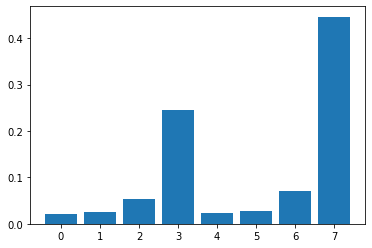

In [65]:
plt.bar(np.arange(len(y_pred)), y_pred)

In [ ]:
X_test = []
xs = [format(x, '0{}b'.format(3)) for x in list(range(8))]
for state in [format(x, '0{}b'.format(3)) for x in list(range(8))]:
    X_test.append([int(a)*b for a, b in zip(state, candidate)])
y_pred = gfp_regr.predict(X_test)
dr = y_pred[-1]/y_pred[:-1].max()
X_test, y_pred, dr

In [ ]:
gfp_regr.predict([[0.6776408602092698, 7.855044785951622, 58.55498594885952]])